# Chapter 4 - Policy Gradient Methods

## 3. OpenAI Gym 다루기

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import numpy as np
import torch
import gym
import matplotlib.pyplot as plt

### Listing 4.1 OpenAI Gym 환경 나열

In [6]:
from gym import envs

In [11]:
envs.registry.values(), len(envs.registry.values())

(dict_values([EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=0), EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=1), EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='MountainCar', version=0), EnvSpec(id='MountainCarContinuous-v0', entry_point='gym.envs.classic_control.c

### 3.2 OpenAI Gym API

#### Listing 4.2 OpenAI Gym 의 환경 생성

In [16]:
import gym

In [17]:
env = gym.make('CartPole-v0')

#### Listing 4.3 동작 선택 및 실행

In [18]:
state1 = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)

## 4. REINFORCE 알고리즘

### 4.1 정책망 구축

#### Listing 4.4 정책망 구축

In [19]:
import gym
import numpy as np
import torch

In [39]:
l1 = 4  # 입력 데이터의 길이(성분 개수)는 4이다("l1" 은 layer 1, 즉 신경망의 첫 번째 층을 뜻한다).
l2 = 150  # 중간층은 150 차원 벡터를 산출한다.
l3 = 2  # 최종 출력은 두 동작(좌 이동, 우 이동)의 확률들을 담은 2차원 벡터이다.

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(),  # 출력층은 소프트맥스 함수를 이용해서 동작들에 관한 확률분포를 산출한다.
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 4.2 에이전트와 환경의 상호작용

#### Listing 4.5 정책망을 이용한 동작 선택

In [22]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float())  # 정책망을 실행해서 동작 확률들을 예측한다.
action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())  # 정책망이 산출한 확률분포에서 동작을 하나 추출한다.
state2, reward, done, info = env.step(action)  # 동작을 실행해서 새 상태와 보상을 받는다. info 변수에는 환경이 제공한 정보가 담기는데, 이 예제에서는 사용하지 않는다.

### 4.3 모형의 훈련

#### Listing 4.6 할인된 보상 계산

In [23]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards  # 지수적으로 감소하는 보상들을 계산한다.
    disc_return /= disc_return.max()  # 수치 안정성을 위해 보상들을 [0, 1] 구간으로 정규화한다.
    return disc_return

#### Listing 4.7 손실함수 정의

In [24]:
def loss_fn(preds, r):  # 이 함수는 취한 동작들의 확률들을 담은 배열과 할인된 보상들을 담은 배열을 받는다.
    return -1 * torch.sum(r * torch.log(preds))  # 각 동작의 로그 확률에 할인된 보상을 곱한 값들을 모두 합한 후 부호를 바꾼 것이 손실값이다.

### 4.4 전체 훈련 루프

#### Listing 4.8 REINFORCE 훈련 루프

In [47]:
l1 = 4  # 입력 데이터의 길이(성분 개수)는 4이다("l1" 은 layer 1, 즉 신경망의 첫 번째 층을 뜻한다).
l2 = 150  # 중간층은 150 차원 벡터를 산출한다.
l3 = 2  # 최종 출력은 두 동작(좌 이동, 우 이동)의 확률들을 담은 2차원 벡터이다.

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(),  # 출력층은 소프트맥스 함수를 이용해서 동작들에 관한 확률분포를 산출한다.
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
from tqdm import tqdm

In [49]:
MAX_DUR = 200
MAX_EPISODES = 1000
gamma = 0.99
score = []  # 에피소드 길이들의 목록

for episode in tqdm(range(MAX_EPISODES)):
    curr_state = env.reset()
    done = False
    transition = []  # 상태, 동작, 보상 튜플들의 목록
    
    for t in range(MAX_DUR):  # 게임 종료 또는 최대 시간 단계까지 반복한다.
        act_prob = model(torch.from_numpy(curr_state).float())  # 동작 확률들을 얻는다.
        action = np.random.choice(np.array([0, 1]), p=act_prob.data.numpy())  # 확률적으로 동작 하나를 선택한다.
        prev_state = curr_state
        curr_state, _, done, info = env.step(action)  # 환경에서 그 동작을 실행한다.
        transition.append((prev_state, action, t+1))  # 현재 상태, 동작, 보상 튜플을 해당 목록에 저장한다.
        if done:  # 게임에서 패배하면 루프를 벗어난다.
            break
            
    ep_len = len(transition)  # 에피소드 길이를 해당 목록에 저장한다.
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s, a, r) in transition]).flip(dims=(0, ))  # 에피소드의 보상들을 모아서 하나의 텐서에 담는다.
    disc_returns = discount_rewards(reward_batch)  # 할인된 보상들을 계산한다.
    state_batch = torch.Tensor([s for (s, a, r) in transition])  # 에피소드의 상태들을 모아서 하나의 텐서에 담는다.
    action_batch = torch.Tensor([a for (s, a, r) in transition])  # 에피소드의 동작들을 모아서 하나의 텐서에 담는다.
    pred_batch = model(state_batch)  # 에피소드의 모든 상태에 대한 동작 확률들을 다시 계산한다.
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1, 1)).squeeze()  # 각 상태에서 실제로 취한 동작의 확률들만 모은다.
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:13<00:00, 73.27it/s]


In [50]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0] - N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [51]:
score = np.array(score)
avg_score = running_mean(score, 50)

In [52]:
avg_score

array([ 19.8 ,  19.74,  19.56,  19.58,  19.48,  19.28,  19.36,  19.36,
        19.4 ,  19.38,  19.32,  18.86,  18.88,  18.9 ,  19.2 ,  19.18,
        19.26,  19.34,  19.22,  18.9 ,  19.32,  18.44,  18.34,  18.48,
        18.42,  18.44,  18.4 ,  18.26,  18.2 ,  18.3 ,  18.44,  18.44,
        18.2 ,  18.42,  18.6 ,  19.02,  18.96,  19.02,  18.64,  18.6 ,
        18.66,  18.68,  18.66,  18.88,  19.28,  19.  ,  18.54,  18.48,
        18.5 ,  18.66,  18.68,  18.5 ,  18.5 ,  18.52,  18.58,  18.62,
        18.58,  19.14,  19.12,  19.18,  19.2 ,  19.3 ,  19.24,  19.26,
        18.96,  18.7 ,  18.44,  18.  ,  18.08,  18.1 ,  18.  ,  18.24,
        18.58,  18.5 ,  18.6 ,  18.96,  18.9 ,  18.98,  19.36,  19.36,
        19.36,  19.46,  19.14,  18.96,  19.02,  18.9 ,  18.94,  18.68,
        18.74,  18.84,  18.74,  18.8 ,  19.04,  19.26,  18.9 ,  18.66,
        18.86,  18.86,  18.8 ,  18.6 ,  18.5 ,  18.6 ,  19.12,  19.16,
        19.04,  18.94,  19.68,  19.34,  19.34,  19.24,  19.3 ,  19.34,
      

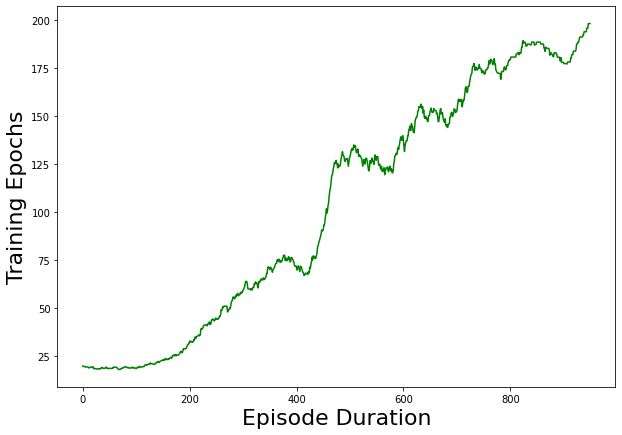

In [53]:
plt.figure(figsize=(10, 7))
plt.xlabel('Episode Duration', fontsize=22)
plt.ylabel('Training Epochs', fontsize=22)
plt.plot(avg_score, color='green')
plt.show()

#### Listing 4.9

In [54]:
score = []
games = 100
done = False
state1 = env.reset()
for i in range(games):
    t = 0
    while not done:
        pred = model(torch.from_numpy(state1).float())
        action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
        state2, reward, done, info = env.step(action)
        state1 = state2
        t += 1
        if t > MAX_DUR:
            break
    state1 = env.reset()
    done = False
    score.append(t)
score = np.array(score)

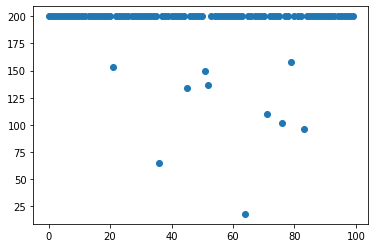

In [55]:
plt.scatter(np.arange(score.shape[0]), score)